## CrossRef evaluation

In [1]:
### All Imports
import ast
import json
import pylab as p
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
sns.set_style('dark')

In [3]:
## Loading the file which contains the 10000 random citations
selected_citations = pd.read_csv('selected_citations_for_evaluation_10000.csv')

In [4]:
## Reading the file which contains 10000 citations which are random in nature
selected_citations.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
selected_citations.head()

,authors_list,citation_title,citation,page_title,id_list,DOI
0,"['Friedrich B', 'Feng Y', 'Cohen P', 'Risler T...",The serine/threonine kinases SGK2 and SGK3 are...,Map(Title -> The serine/threonine kinases SGK2...,SGK2,"[['PMID', '12632189'], ['DOI', '10.1007/s00424...",10.1007/s00424-002-0993-8
1,"['Scherer Stephen', 'Cheung J', 'MacDonald JR'...",Human Chromosome 7: DNA Sequence and Biology,Map(Title -> Human Chromosome 7: DNA Sequence ...,Ectrodactyly,"[['PMID', '12690205'], ['PMC', '2882961'], ['D...",10.1126/science.1083423
2,"['Kuiper GG', 'Carlsson B', 'Grandien K', 'Enm...",Comparison of the ligand binding specificity a...,Map(Title -> Comparison of the ligand binding ...,Androstenedione,"[['PMID', '9048584'], ['DOI', '10.1210/endo.13...",10.1210/endo.138.3.4979
3,['Makepeace Tsao'],A New Synthesis of Mescaline,"Map(Title -> A New Synthesis of Mescaline, Vol...",Mescaline,"[['DOI', '10.1021/ja01155a562']]",10.1021/ja01155a562
4,['Rennie David'],Two Thoughts on Abraham Maslow.,"Map(Title -> Two Thoughts on Abraham Maslow., ...",Abraham Maslow,"[['DOI', '10.1177/0022167808320537']]",10.1177/0022167808320537


In [5]:
print(
    'Number of total citations: {} and number with unique title: {}'.format(
        selected_citations.shape[0], selected_citations['citation_title'].nunique())
)

Number of total citations: 10000 and number with unique title: 9707


In [6]:
## Getting the author and title for each of the unique random citations we have
def get_params(dataset):
    params = []
    for i in range(dataset.shape[0]):
        r_dict = dict()
        title_ = dataset.iloc[i]['citation_title']
        r_dict['query.bibliographic'] = title_
        author = ast.literal_eval(dataset.iloc[i]['authors_list'])[0]
        if author != 'No authors':
            r_dict['query.author'] = author
            r_dict['DOI'] = dataset.iloc[i]['DOI']
            params.append(r_dict)

    print('Constructed parameters for requests')
    return params

In [7]:
params = get_params(selected_citations)
print('Total number of unique params: {}'.format(len(params)))

Constructed parameters for requests
Total number of unique params: 9764


In [8]:
## Get all the indices and shuffle them 
indices = np.arange(len(params))
np.random.shuffle(indices)

In [9]:
## Make a train and test split for checking which heuristic is the best heuristic
SPLIT_THRESHOLD = (len(params) * 80) // 100
 
training_indices = indices[:SPLIT_THRESHOLD]
testing_indices = indices[SPLIT_THRESHOLD:]

training_content = [j for i, j in enumerate(params) if i in training_indices]
training_dois = [i['DOI'] for i in training_content]
testing_content  = [j for i, j in enumerate(params) if i in testing_indices]
testing_dois = [i['DOI'] for i in testing_content]

In [10]:
## taking in the column of score as the threshold and putting title, author, and DOI in dataframe
def get_eval(score_number, training=True):
    
    indices__, dois__, content = None, None, None
    if training:
        indices__, dois__, content = training_indices, training_dois, training_content
    else:
        indices__, dois__, content = testing_indices, testing_dois, testing_content
        
    crossref_invalid = 0 ## Requests which are not present in CrossRef for some reason
    no_result_for_heuristic = 0
    
    info_threshold = []
    for i in tqdm_notebook(range(len(indices__))):
    
        with open('lookup_eval_queried/result_{}.txt'.format(indices__[i])) as f:
            file_content = json.loads(f.read())
        
        if 'items' not in file_content['message'] or len(file_content['message']['items']) == 0:
            crossref_invalid += 1
            continue

        if len(file_content['message']['items']) <= score_number:
            no_result_for_heuristic += 1
            continue
            
        res = file_content['message']['items'][score_number] ## score_number represents the threshold
        res_doi = res.get('DOI', 'No DOI')
        res_title = res.get('title', ['No title'])[0]
        res_score = res.get('score', 'No score')
        info_threshold.append([res_doi, res_title, res_score])

    take_score = pd.DataFrame(info_threshold)
    take_score.rename({0: 'ID', 1: 'title', 2: 'score'}, axis=1, inplace=True)

    present = []
    not_present = []
    for i, j, l in zip(list(take_score['ID']), list(take_score['score']), list(take_score['title'])):
        if i in dois__:
            present_res = [k for k in content if k['DOI'] == i]
            present.append([i, j, l, present_res])
        else:
            not_present.append([i, j, l])
    print('Total number of retreieved IDs present in original: {}'.format(len(present)))
    print('Total number of retreieved IDs NOT present in original: {}'.format(len(not_present)))
    print('Total number of IDs for which CrossRef request is not valid: {}'.format(crossref_invalid))
    print('Total number of IDs for which there is no result for that heuristic: {}'.format(no_result_for_heuristic))
    return present, not_present

In [11]:
present_first_score, not_present_first_score = get_eval(0)


Total number of retreieved IDs present in original: 5246
Total number of retreieved IDs NOT present in original: 2524
Total number of IDs for which CrossRef request is not valid: 41
Total number of IDs for which there is no result for that heuristic: 0


In [12]:
present_second_score, not_present_second_score = get_eval(1)


Total number of retreieved IDs present in original: 364
Total number of retreieved IDs NOT present in original: 7396
Total number of IDs for which CrossRef request is not valid: 41
Total number of IDs for which there is no result for that heuristic: 10


In [13]:
present_third_score, not_present_third_score = get_eval(2)


Total number of retreieved IDs present in original: 100
Total number of retreieved IDs NOT present in original: 7651
Total number of IDs for which CrossRef request is not valid: 41
Total number of IDs for which there is no result for that heuristic: 19


In [14]:
print('Is 2nd threshold any better: {}'.format(
    any([True if i in not_present_first_score else False for i in present_second_score])))
print('Is 3rd threshold any better: {}'.format(
    any([True if i in not_present_first_score else False for i in present_third_score])))

Is 2nd threshold any better: False
Is 3rd threshold any better: False


From the part above, we see that the best heuristic is given by the item which has the highest score or the one which is first in the list by index. Now, we check it on the testing set..

### Testing part just check the best threshold gained in the first part

In [15]:
print('Total points in the testing set: {}'.format(len(testing_indices)))

Total points in the testing set: 1953


In [16]:
## Passing 0 as the parameter as we know the first is the best heuristic
presenting_testing_score, not_present_testing_score = get_eval(0, training=False)


Total number of retreieved IDs present in original: 1331
Total number of retreieved IDs NOT present in original: 615
Total number of IDs for which CrossRef request is not valid: 7
Total number of IDs for which there is no result for that heuristic: 0


In [17]:
presenting_testing_score[229], presenting_testing_score[17]

(['10.2174/138527206776894410',
  41.56121,
  'Natural Product Inhibitors of Acetylcholinesterase',
  [{'query.bibliographic': 'Natural Product Inhibitors of Acetylcholinesterase',
    'query.author': 'Hostettmann K',
    'DOI': '10.2174/138527206776894410'}]],
 ['10.1073/pnas.93.25.14480',
  67.9136,
  'A small nucleolar RNA requirement for site-specific ribose methylation of rRNA in Xenopus',
  [{'query.bibliographic': 'A small nucleolar RNA requirement for site-specific ribose methylation of rRNA in Xenopus',
    'query.author': 'Tycowski Kazimierz T.',
    'DOI': '10.1073/pnas.93.25.14480'}]])

1. x-axis: confidence scores (please let me know the range, pick 100 uniform intervals)
2. y-axis: relative precision and recall (2 lines, use different colours and add a legend). By relative P and R I mean:
    1. Relative precision: number of correctly matched DOIs using the given threshold divided by the total number of matches above the threshold (takes values between 0 and 1, it should go up as the threshold goes up). So, for example, if you use a dataset of 100 citations, you look them all up, you use a threshold of 0.5 and have 60 matches above this threshold, and of these 60 you have 50 that are correct, your precision is 50/60 = 0.83
    2. Relative recall: number of correctly matched DOIs using the given threshold divided by the total number of matches above the threshold (takes values between 0 and 1, it should go down as the threshold goes up). So, for example, if you use a dataset of 100 citations, you look them all up, you use a threshold of 0.5 and have 60 matches above this threshold, and of these 60 you have 50 that are correct, your recall is 50/100 = 0.5

In [18]:
all_scores = [i[1] for i in present_first_score] + [i[1] for i in not_present_first_score]

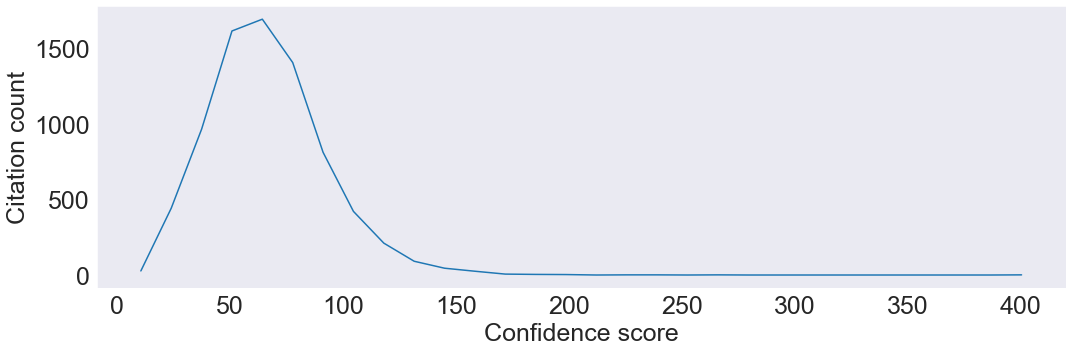

In [19]:
## Print the histogram for the confidence scores with bins and set
y, binEdges = np.histogram(all_scores, bins=30)
bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])
params = {
    'figure.figsize': (15, 5), 'axes.labelsize': '25', 
    'axes.titlesize': '25', 'xtick.labelsize': '25', 'ytick.labelsize': '25'
}
p.rcParams.update(params)

p.plot(bincenters, y, '-')
p.xlabel('Confidence score')
p.ylabel('Citation count')
p.tight_layout()
p.savefig('crossref_one.png')

In [20]:
all_data = [i for i in present_first_score] + [i for i in not_present_first_score]

In [21]:
## Get the equivalent intervals between the max and minimum confidence scores
start = min(all_scores)
end = max(all_scores)
intervals = np.linspace(0, end, 30)

In [22]:
print('Total number of unique training split points: {}'.format(len(all_data)))

Total number of unique training split points: 7770


In [23]:
all_dois = [i[0] for i in all_data]

In [24]:
graph_result = []
for ind in range(len(intervals) - 1):
    subset_interval = [
        i for i in all_data
        if i[1] >= intervals[ind]
    ]
    subset_len_four = sum([1 for i in subset_interval if len(i) == 4])
    if subset_len_four == 0:
        graph_result.append([intervals[ind], intervals[ind + 1], len(subset_interval), 0, 0])
    else:
        precision = subset_len_four / len(subset_interval)
        recall = subset_len_four / len(all_data)
        graph_result.append([intervals[ind], intervals[ind + 1], len(subset_interval), precision, recall])

In [25]:
print(intervals)
print('\nTotal number of intervals are: {}'.format(len(graph_result)))

[  0.          14.04639724  28.09279448  42.13919172  56.18558897
  70.23198621  84.27838345  98.32478069 112.37117793 126.41757517
 140.46397241 154.51036966 168.5567669  182.60316414 196.64956138
 210.69595862 224.74235586 238.7887531  252.83515034 266.88154759
 280.92794483 294.97434207 309.02073931 323.06713655 337.11353379
 351.15993103 365.20632828 379.25272552 393.29912276 407.34552   ]

Total number of intervals are: 29


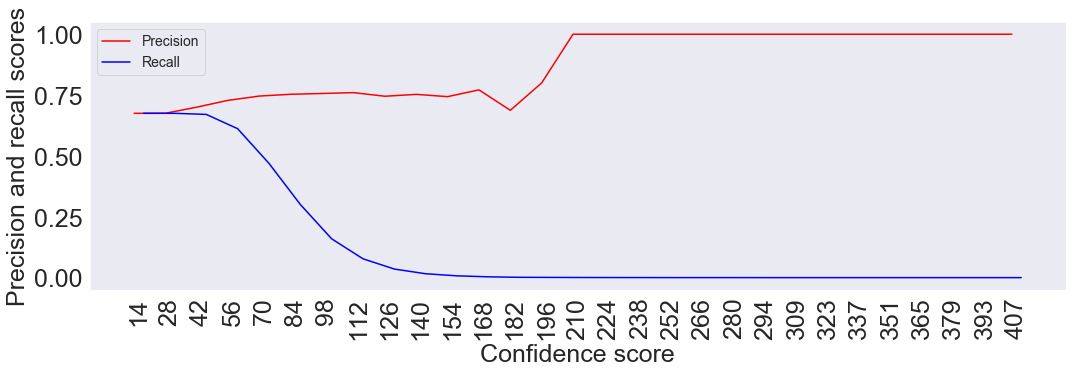

In [26]:
N = len(graph_result)
n_precision = [i[3] for i in graph_result]

ind = np.arange(N)  # the x locations for the groups
width = 0.3      # the width of the bars

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)

rects1 = ax.plot(ind, n_precision, width, color='r')

n_recall = [i[4] for i in graph_result]
rects2 = ax.plot(ind + width, n_recall, width, color='b')

# add some text for labels, title and axes ticks
ax.set_xlabel('Confidence score')
ax.set_ylabel('Precision and recall scores')
ax.set_xticks(ind + width / 2)

plt.tight_layout()

ax.legend((rects1[0], rects2[0]), ('Precision', 'Recall'), prop={'size': 14})

n_xticklabels = [int(i[1]) for i in graph_result]
ax.set_xticklabels(n_xticklabels, rotation='vertical')

interval_info = [i[2] for i in graph_result]

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(25)

plt.savefig('crossref_two.png')
plt.show()

In [27]:
print('At threshold: 34.997, the precision is: {}'.format(np.interp(34.997, n_xticklabels, n_precision)))
print('At threshold: 34.997, the recall is: {}'.format(np.interp(34.997, n_xticklabels, n_recall)))

At threshold: 34.997, the precision is: 0.6879541438322252
At threshold: 34.997, the recall is: 0.6729095881595881


In [28]:
## Out of 1297, 1246 points are greater than the threshold
print('Number of data points less than the threshold: {}'.format(sum([1 for i in presenting_testing_score if i[1] < 34.997])))

Number of data points less than the threshold: 54


In [29]:
## Out of 646, 521 points are greater than the threshold
print('Number of data points less than the threshold: {}'.format(sum([1 for i in not_present_testing_score if i[1] < 34.997])))

Number of data points less than the threshold: 120


In [30]:
print('The range of min: {} and max: {} confidence scores'.format(min(all_scores), max(all_scores)))

The range of min: 3.658947 and max: 407.34552 confidence scores
